# Protecting Neural Network from Adversarial Examples
## Attack
- FGSM - Fast Gradient Signed Method

## Datasets
- Standard Datasets
  - MNIST
  - FASHION-MNIST
  - CIFAR10

- Non-Standard Datasets
  - malaria
  - oxford_flowers102
  - cats_vs_dogs

## Goal
Finding a correlation between Region of Inference (ROI) and Region of Adversarial Attack (ROA) through generation of heatmap of various datasets

## Steps:
1. Do a binary classification between 2 classes
2. Apply FGSM attack and see if the model is able to classify
3. Produce a heatmap of the FGSM attacked image
4. Brighten ROA till to the point it does not exist - Keeping information necessary for ROI - Minimise loss in prediction - Only ROI exist for classification 

In [0]:
## Load Dependencies
# Code uses TensorFlow 2.1 and TensorFlow.Keras dependencies
%tensorflow_version 2.x
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

from skimage.metrics import structural_similarity,mean_squared_error,normalized_root_mse
from IPython.utils import io 
from multiprocessing import pool

from google.colab import drive

import skimage
import tensorflow_datasets as tfds
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import datetime
import random
import gzip
import copy
import cv2


## Set GPU Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

tf.enable_v2_behavior()
print(gpus)

TensorFlow 2.x selected.
[]


## Choose Dataset for VGG16 
- Standard datasets
  - MNIST
  - Fashion MNIST
  - Cifar10

We need to setup the dataset images, (28, 28, 1) for MNIST and Fashion MNIST, and (32, 32, 3) for cifar10 to (48, 48, 3) to fit VGG16 image input requirements

- Non standard datasets
  - malaria
  - oxford_flowers102
  - cats_vs_dogs

For non standard datasets, we will standardize the image size to be (125, 125, 3) / (224, 224, 3) to fit VGG16 image input requirements.

In [0]:
## Function to load dataset
def load_dataset(dataset, display_examples=False):
  if dataset == "mnist":
  ## Load MNIST dataset ##
    mnist_train_display, mnist_information = tfds.load(dataset, 
                                                      split="train", 
                                                      with_info=True)
    mnist_test_display = tfds.load(dataset, 
                                  split="test")
    if display_examples == True:
      tfds.show_examples(mnist_information, mnist_train_display)
    return mnist_train_display, mnist_test_display  
  
  elif dataset == "fashion_mnist":
  ## Load Fashion MNIST dataset ##
    fashion_mnist_train_display, fashion_mnist_info = tfds.load(dataset, 
                                                                split="train", 
                                                                with_info=True)
    fashion_mnist_test_display = tfds.load(dataset, 
                                          split="test")

    if display_examples == True:
      tfds.show_examples(fashion_mnist_info, fashion_mnist_train_display)
    return fashion_mnist_train_display, fashion_mnist_test_display
  
  elif dataset == "cifar10":
  ## Load CIFAR-10 dataset ##
    cifar10_train_display, cifar10_info = tfds.load(dataset, 
                                                    split="train", 
                                                    with_info=True)
    cifar10_test_display = tfds.load(dataset, 
                                    split="test")
    
    if display_examples == True:
      tfds.show_examples(cifar10_info, cifar10_train_display)
    return cifar10_train_display, cifar10_test_display
  
  elif dataset == "malaria":
  # Load malaria dataset ##  
    malaria_train_display, malaria_info = tfds.load(dataset, 
                                                      split="train", 
                                                      with_info=True)
    malaria_test_display = tfds.load(dataset, 
                                    split="train[:20]")
    if display_examples == True:
      tfds.show_examples(malaria_info, malaria_train_display)
    return malaria_train_display, malaria_test_display
  
  elif dataset == "oxford_flowers102":
  ## Load oxford_flowers dataset ##
    oxford_train_display, oxford_info = tfds.load(dataset, 
                                                  split="train", 
                                                  with_info=True)
    oxford_test_display = tfds.load(dataset, 
                                    split="test")
    if display_examples == True:
      tfds.show_examples(oxford_info, oxford_train_display)
    return oxford_train_display, oxford_test_display
  
  elif dataset == "cats_vs_dogs":
  ## Load cats_vs_dogs dataset ##
    cats_vs_dogs_train_display, cats_vs_dog_info = tfds.load(dataset, 
                                                            split="train", 
                                                            with_info=True)
    cats_vs_dogs_test_display = tfds.load(dataset, 
                                          split="train[:20]")
    if display_examples == True:
      tfds.show_examples(cats_vs_dog_info, cats_vs_dogs_train_display)
    return cats_vs_dogs_train_display, cats_vs_dogs_test_display

### Resizing function for each dataset

In [0]:
## Function to resize dataset to fit VGG16
def resize(dataset, depth, leftSide):
  "Dataset: Type of dataset"
  def perform_action(x):
    # Normalize data
    x["image"] = tf.cast(x["image"], tf.float32) / 255.0
    x["image"] = tf.image.resize(x["image"], [224, 224])
    if dataset == "mnist" or dataset == "fashion_mnist":
      x["image"] = tf.concat([x["image"], x["image"], x["image"]], 2)
    if depth == 2:
      # Depth refers to the number of classes
      # One hot encode
      x["label"] = tf.one_hot(0 if x["label"] == int(leftSide) else 1,
                              depth=depth)
    else:
      x["label"] = tf.one_hot(x["label"], 
                              depth=depth)
    return x
  return perform_action 
  

In [0]:
## Function to extract specific class out of a dataset for binary classification
def take_class(labelNumber = [0.]):
    if not isinstance(labelNumber, collections.Sequence):
        labelNumber = [labelNumber]
    def predicate(x, allowed_labels=tf.constant(labelNumber)):
      label = x["label"]
      isallowed = tf.equal(allowed_labels, tf.cast(label, tf.float32))
      reduced = tf.reduce_sum(tf.cast(isallowed, tf.float32))
      return tf.greater(reduced, tf.constant(0.))
    return predicate

In [0]:
## Fix dataset for Non-Standard Datasets
def fix_dataset(x):
  y = {"image": x["image"], "label": x["label"]}
  return y

### Create Adversarial Attack using FGSM

In [0]:
## Function to perform FGSM attack
def adversarial_pattern(model, image, label, gradient_sign=1):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    
    gradient = tape.gradient(loss, image)
    signed_grad = gradient_sign * tf.sign(gradient)
    return signed_grad

In [0]:
## Helper code to produce nice perturbed image
def produce_adversarial_image(model, image, label, epsilon=0.1, gradient_sign=1):
  perturbations = adversarial_pattern(model, tf.stack([image], axis=0), 
                                      label, 
                                      gradient_sign=gradient_sign
                                      ).numpy()
  adversarial = image + perturbations * epsilon
  return adversarial[0], perturbations[0]

### Prediction Function

In [0]:
## Function to predict raw image
def predict_label_on_image_raw(model, image):
  if len(image) == 4:
    return model.predict(image)
  else:
    return model.predict(tf.stack([image], 
                                  axis=0))

In [0]:
## Function to predict image based on label
def predict_label_on_image(model, image, display_info=False):
  if len(image) == 4:
    if display_info == True:
      print("Label: {0}\n{1}".format(predict_label_on_image_raw(model, image).argmax(), 
                                     predict_label_on_image_raw(model, image)))
    return total_label_list[predict_label_on_image_raw(model, image).argmax()]
  else:
    if display_info == True:
      print("Label: {0}\n{1}".format(predict_label_on_image_raw(model, image).argmax(), 
                                     predict_label_on_image_raw(model, image)))
    return total_label_list[predict_label_on_image_raw(model, image).argmax()]

In [0]:
## Function to obtain label
def get_label(label, display_info=False):
  if display_info == True:
    print("Label: {0} \n{1}".format(np.argmax(label), label))
  return total_label_list[np.argmax(label)]

In [0]:
def best_effort_error_prone_adv_image(model, img, label):
  # Loop through the ranges to see the lowest possible epsilon to fool the model
  for i in np.arange(0.1, 0.6, 0.01):
    img, per = produce_adversarial_image(model, img, label, epsilon=i)
    current_label = get_label(label)
    adv_label = predict_label_on_image(model, img)
    if not current_label == adv_label:
      return img, i
  return None, None

### ROI and ROA
- Region of Inference
- Region of Adversarial Attack

In [0]:
# Function to generate heatmap of ROI
def generate_heatmap_region_inference(model, image):
    """
    https://stackoverflow.com/a/58323113
    At the end of the GradientTape loop, conv_output and yes
    grads already holds the value. The iterate function is no 
    longer need to compute the values.
    """
    img_tensor = image
    print(img_tensor.shape)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    print(img_tensor.shape)

    # Obtain image from output layer
    conv_layer = model.get_layer('conv2d_12')
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = heatmap_model(img_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = tape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = np.mean(tf.multiply(conv_output[0], pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

In [0]:
# Function to generate heatmap of ROA
def generate_heatmap_region_adversarial(dataset, model, total_label_list, eps):

  heatmap_arr = []

  _, data_test = load_dataset(dataset)

  for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[1])).map(resize(dataset, number_of_classes, total_label_list[0])).batch(1):
                                                                                      
    (adv, perturb) = produce_adversarial_image(model, 
                                               batch["image"][0].numpy(),
                                               batch["label"], 
                                               epsilon=eps, 
                                               gradient_sign=1)
    
    perturb *= 0.1
    heatmap_arr.append(perturb)

  heatmap = np.asarray(heatmap_arr)
  
  return heatmap

In [0]:
def img_roi_representation(dataset, total_label_list):

  if dataset == "malaria":
    size = (128, 128)
  elif dataset == "oxford_flowers102" or dataset == "cats_vs_dogs":
    size = (224, 224)
  elif dataset == "mnist" or dataset == "fashion_mnist" or dataset == "cifar10":
    size = (48, 48)

  img = None

  for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[1])).map(resize(dataset, 
                                                                                                                  number_of_classes, 
                                                                                                                  total_label_list[0])).take(3):
    plt.figure()
    plt.imshow(batch["image"])
    # plt.xlabel("Predicted: {0}".format(np.argmax(batch["label"])))
    plt.show()
      
    image = batch["image"]
    heatmap = generate_heatmap_region_inference(model, image)
    plt.matshow(heatmap)
    plt.show()

    heatmap_original = cv2.resize(heatmap, size)

    plt.imshow(heatmap_original)
    plt.show()

    heatmap = np.uint8(255 * heatmap_original)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    plt.imshow(heatmap)

    img = batch["image"]
  
  return heatmap  


In [0]:
def clear_gpu():
  tf.keras.backend.clear_session()  # For easy reset of notebook state.

## Experimental Phase
- MNIST
- Fashion_MNIST
- CIFAR10
- Malaria
- oxford_flowers102
- cats_vs_dogs

In [0]:
clear_gpu()

In [0]:
dataset = input()

cats_vs_dogs


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2EAMCL/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


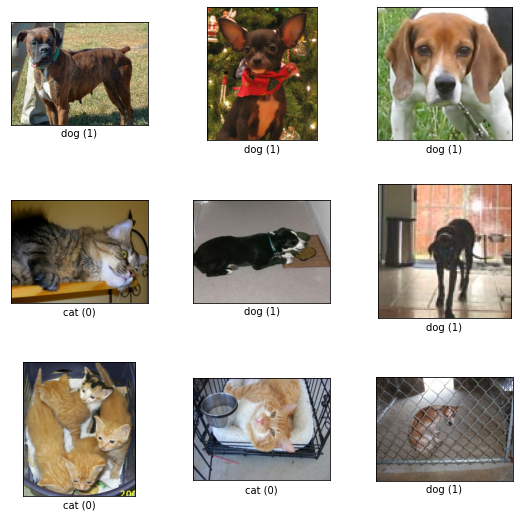

In [0]:
data_train, data_test = load_dataset(dataset, display_examples=True)
data_train_display, data_test_display = load_dataset(dataset)

In [0]:
# No. of classes
number_of_classes = 2
# Input dimensions
img_rows, img_cols, channels = 224, 224, 3
l_rate = 1e-5
# Validation Step
valid_step = 5
# Steps per Epoch
steps_per_ep = 30

if dataset == "mnist" or dataset == "fashion_mnist":
  number_of_steps = 10
elif dataset == "cifar10" or dataset == "malaria":
  number_of_steps = 50
elif dataset == "oxford_flowers102":
  number_of_steps = 2
elif dataset == "cats_vs_dogs":
  number_of_steps = 100

In [0]:
def vgg16_model(dataset, l_rate):

    model = Sequential()
    # Conv Block 1
    model.add(Conv2D(64, 
                     (3, 3), 
                     input_shape=(img_rows, img_cols, channels), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(64, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2)))

    # Conv Block 2
    model.add(Conv2D(128, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(128, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2)))

    # Conv Block 3
    model.add(Conv2D(256, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(256, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(256, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),
                           strides=(2, 2)))

    # Conv Block 4
    model.add(Conv2D(512, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(512, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(512, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2)))

    # Conv Block 5
    model.add(Conv2D(512, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(512, 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(512, 
                     (3, 3), 
                     activation='relu', 
                     padding='same',
                     name='conv2d_12'))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2)))

    # FC layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    
    optimizer = optimizers.Adam(learning_rate=l_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [0]:
def generate_model(dataset, total_label_list, target_label, number_of_steps, l_rate):
  
  number_of_classes = len(total_label_list)
  # Prepare dataset
  data_train_batch = data_train.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list)).map(resize(dataset, 
                                                                                                                      number_of_classes, 
                                                                                                                      leftSide=total_label_list[0])).map(fix_dataset).batch(12).repeat()
  data_test_batch = data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list)).map(resize(dataset, 
                                                                                                                    number_of_classes,  
                                                                                                                    leftSide=total_label_list[0])).map(fix_dataset).batch(12).repeat()

  # Because keras likes tuples, and tf-dataset uses dictionaries, you need to convert to tuple form!
  # https://stackoverflow.com/q/56134016
  train_data = data_train_batch.map(lambda x: tuple(x.values()))
  test_data = data_test_batch.map(lambda x: tuple(x.values()))

  # Invoke Model
  model = vgg16_model(dataset, l_rate=l_rate)

  model.fit(train_data, 
            verbose=2, 
            validation_data=test_data, 
            validation_steps=valid_step,
            epochs=number_of_steps, 
            steps_per_epoch=steps_per_ep
            )
    
  return model

In [0]:
total_label_list = [0., 1.]

In [0]:
model = generate_model(dataset, total_label_list=total_label_list, target_label=total_label_list[1], number_of_steps=number_of_steps, l_rate=l_rate)

Train for 30 steps, validate for 5 steps
Epoch 1/300
30/30 - 698s - loss: 0.6932 - accuracy: 0.4667 - val_loss: 0.6921 - val_accuracy: 0.6154
Epoch 2/300
30/30 - 695s - loss: 0.6934 - accuracy: 0.4917 - val_loss: 0.6946 - val_accuracy: 0.3846
Epoch 3/300
30/30 - 693s - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4038
Epoch 4/300
30/30 - 696s - loss: 0.6930 - accuracy: 0.5278 - val_loss: 0.6934 - val_accuracy: 0.4231
Epoch 5/300
30/30 - 696s - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6925 - val_accuracy: 0.6731
Epoch 6/300
30/30 - 695s - loss: 0.6931 - accuracy: 0.4917 - val_loss: 0.6930 - val_accuracy: 0.4038
Epoch 7/300
30/30 - 695s - loss: 0.6926 - accuracy: 0.5583 - val_loss: 0.6950 - val_accuracy: 0.3846
Epoch 8/300
30/30 - 694s - loss: 0.6941 - accuracy: 0.5556 - val_loss: 0.6979 - val_accuracy: 0.4038
Epoch 9/300
30/30 - 696s - loss: 0.6933 - accuracy: 0.5083 - val_loss: 0.6955 - val_accuracy: 0.3654
Epoch 10/300
30/30 - 695s - loss: 0.6927 - accurac

KeyboardInterrupt: ignored

### Non-Adversarial Prediction & Adversarial Prediction

Label: 0 
[1. 0.]
Label: 0
[[0.9942311  0.00576895]]


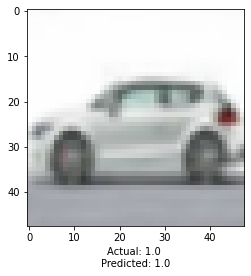

Label: 0 
[1. 0.]
Label: 0
[[0.99604356 0.00395645]]


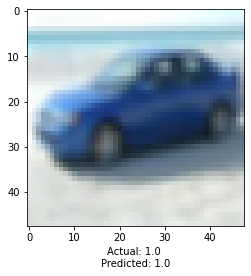

In [0]:
## Non adversarial prediction
for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[0])).map(resize(dataset,number_of_classes, total_label_list[0])).take(2):
  plt.figure()
  plt.imshow(batch["image"])
  plt.xlabel("Actual: {0} \nPredicted: {1}".format(get_label(batch["label"].numpy(), display_info=True), 
                                                   predict_label_on_image(model, batch["image"], display_info=True)))
  plt.show()

Label: 1 
[0. 1.]
Label: 1
[[0.01527953 0.98472047]]


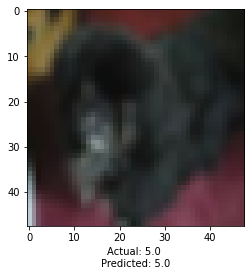

Label: 1 
[0. 1.]
Label: 1
[[0.06865313 0.9313469 ]]


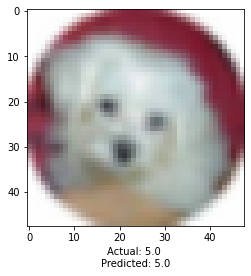

In [0]:
## Non adversarial prediction
for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[1])).map(resize(dataset,number_of_classes, total_label_list[0])).take(2):
  plt.figure()
  plt.imshow(batch["image"])
  plt.xlabel("Actual: {0} \nPredicted: {1}".format(get_label(batch["label"].numpy(), display_info=True), 
                                                   predict_label_on_image(model, batch["image"], display_info=True)))
  plt.show()

Label: 0
[[0.6380809  0.36191913]]


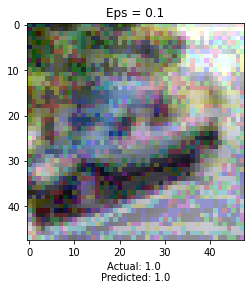

Label: 0
[[0.86970633 0.13029373]]


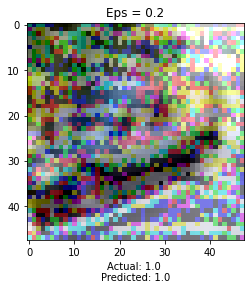

Label: 0
[[0.9866443  0.01335561]]


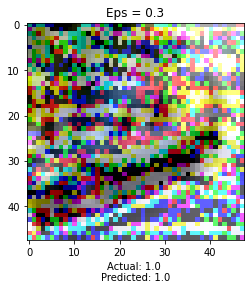

Label: 0
[[0.9989773  0.00102271]]


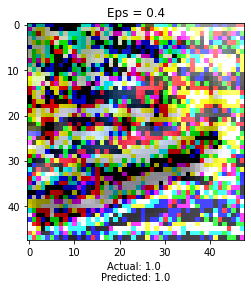

Label: 0
[[9.9991500e-01 8.4932275e-05]]


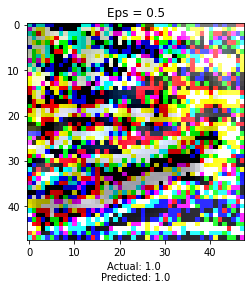

In [0]:
for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[0])).map(resize(dataset,number_of_classes, total_label_list[0])).take(1):

  plt.figure()

  eps = [0.1, 0.2, 0.3]

  for i in eps:
    img, perturb = produce_adversarial_image(model, 
                                            batch["image"], 
                                            batch["label"], 
                                            epsilon=i, 
                                            gradient_sign=1)
    
    plt.title("Eps = {}".format(i))
    plt.imshow(img)
    plt.xlabel("Actual: {0} \nPredicted: {1}".format(get_label(batch["label"].numpy()), predict_label_on_image(model, img, display_info=True)))
    plt.show()

                                                                                
                                                                                                                    

Label: 0
[[0.99294055 0.00705946]]


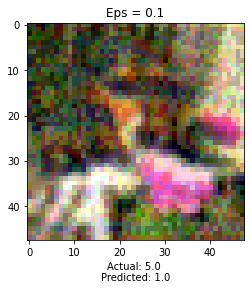

Label: 0
[[9.999335e-01 6.646119e-05]]


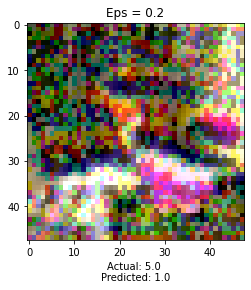

Label: 0
[[9.9999869e-01 1.2670096e-06]]


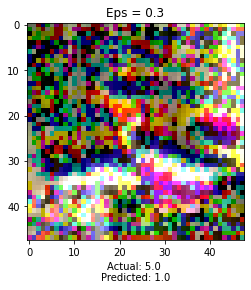

Label: 0
[[1.0000000e+00 4.5274472e-08]]


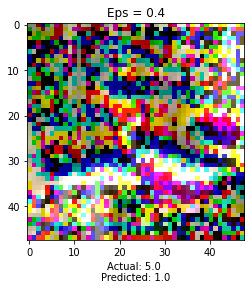

Label: 0
[[1.0000000e+00 2.0487796e-09]]


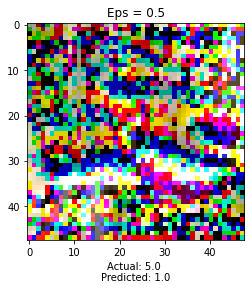

In [0]:
for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[1])).map(resize(dataset, 
                                                                                                                number_of_classes, 
                                                                                                                total_label_list[0])).take(1):

  plt.figure()

  eps = [0.1, 0.2, 0.3, 0.4, 0.5]

  for i in eps:
    img, perturb = produce_adversarial_image(model, 
                                            batch["image"], 
                                            batch["label"], 
                                            epsilon=i, 
                                            gradient_sign=1)
    
    plt.title("Eps = {}".format(i))
    plt.imshow(img)
    plt.xlabel("Actual: {0} \nPredicted: {1}".format(get_label(batch["label"].numpy()), predict_label_on_image(model, img, display_info=True)))
    plt.show()   

## ROI Generation
- Individual Level
- Representative Level

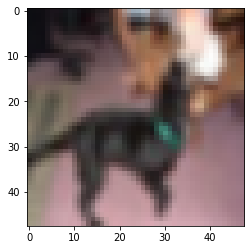

(48, 48, 3)
(1, 48, 48, 3)


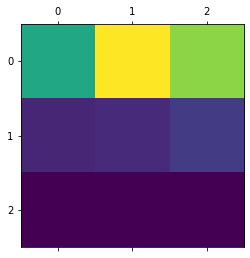

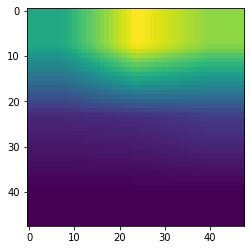

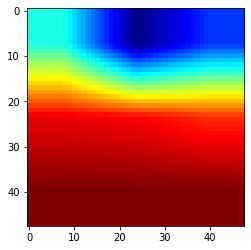

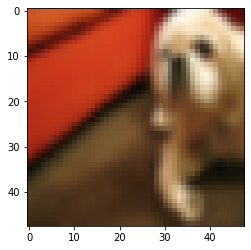

(48, 48, 3)
(1, 48, 48, 3)


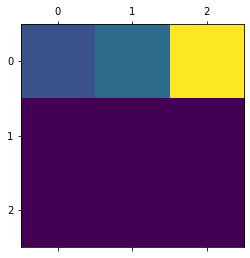

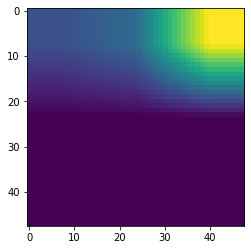

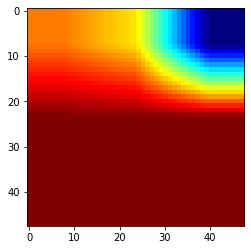

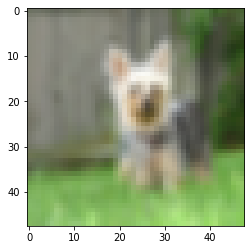

(48, 48, 3)
(1, 48, 48, 3)


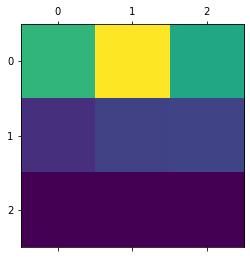

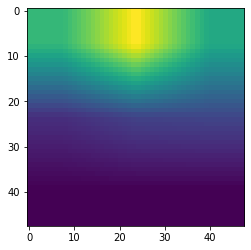

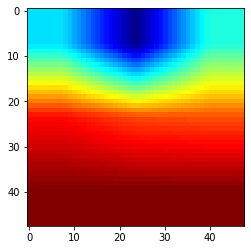

In [0]:
roi_indiv_heatmap = img_roi_representation(dataset=dataset, total_label_list=total_label_list)

(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


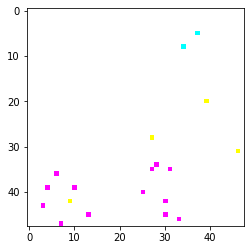

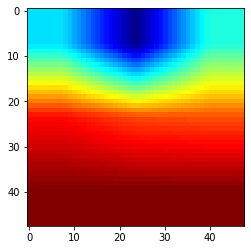

In [0]:
# Applying Heatmap Intensity Factor
hif = .9 # Multiplier 
img = np.uint8(255 * img)
# Sanity check for shape size
print(roi_indiv_heatmap.shape)
print((roi_indiv_heatmap * hif).shape)
print((roi_indiv_heatmap * hif + img).shape)
superimposed_img = roi_indiv_heatmap * hif + img

plt.imshow(superimposed_img)
plt.show()
plt.imshow(roi_indiv_heatmap)
plt.show()

(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(

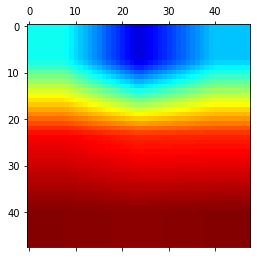

In [0]:
roi_heatmap_stack = []

image = None

for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[1])).map(resize(dataset, 
                                                                                                                number_of_classes, 
                                                                                                                total_label_list[0])).batch(1):    
    image = batch["image"][0]
    heatmap = generate_heatmap_region_inference(model, image)
    roi_heatmap_stack.append(heatmap)

roi_rep_heatmap = np.mean(roi_heatmap_stack, axis=0)
roi_rep_heatmap = cv2.resize(roi_rep_heatmap, (224, 224))
roi_rep_heatmap = np.uint8(255 * roi_rep_heatmap)
roi_rep_heatmap = cv2.applyColorMap(roi_rep_heatmap, cv2.COLORMAP_JET)

# Applying Heatmap Intensity Factor
hif = .9 # Multiplier 
image = np.uint8(255 * image)
# Sanity check for shape size
print(roi_rep_heatmap.shape)
print((roi_rep_heatmap * hif).shape)
print((roi_rep_heatmap * hif + image).shape)
heatmap_modiv = roi_rep_heatmap * hif
superimposed_img = heatmap_modiv + image

plt.imshow(image)
plt.show()
plt.imshow(heatmap_modiv)
plt.show()
plt.imshow(superimposed_img)
plt.show()
plt.imshow(roi_rep_heatmap)
plt.show()

## ROA Generation
- Individual Level
- Representative Level

In [0]:
perturbation_img = generate_heatmap_region_adversarial(dataset, model, total_label_list, 0.1)

(48, 48, 3)


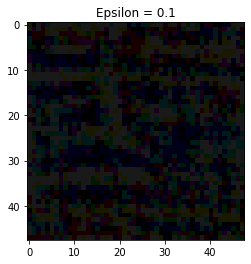

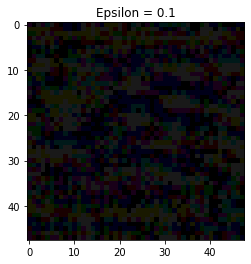

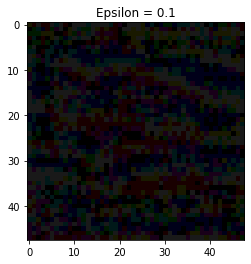

In [0]:
roa_indiv_heatmap = perturbation_img[0]
plt.title("Epsilon = {0}".format("0.1"))
print(roa_indiv_heatmap.shape)
plt.imshow(roa_indiv_heatmap)
plt.show()

roa_indiv_heatmap = perturbation_img[1]
plt.title("Epsilon = {0}".format("0.1"))
plt.imshow(roa_indiv_heatmap)
plt.show()

roa_indiv_heatmap = perturbation_img[2]
plt.title("Epsilon = {0}".format("0.1"))
plt.imshow(roa_indiv_heatmap)
plt.show()

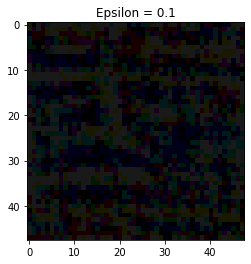

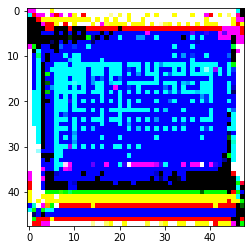

(48, 48, 3)


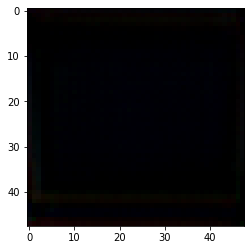

In [0]:
roa_heatmap_image_indiv = perturbation_img[0]
plt.title("Epsilon = 0.1")
plt.imshow(roa_heatmap_image_indiv)
plt.show()

roa_rep_heatmap = np.sum(perturbation_img, axis=0)
plt.imshow(roa_rep_heatmap)
plt.show()

roa_rep_heatmap = np.mean(perturbation_img, axis=0)
print(roa_rep_heatmap.shape)
plt.imshow(roa_rep_heatmap)
plt.show()

## Adding ROA Blob to image to mitigate Adversarial Attack

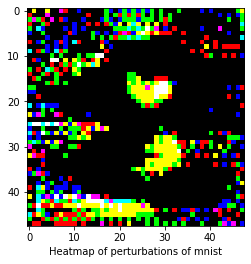

Label: 1
[[5.702156e-05 9.999430e-01]]


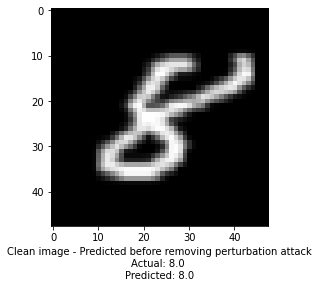

Label: 1
[[0.35524288 0.6447571 ]]


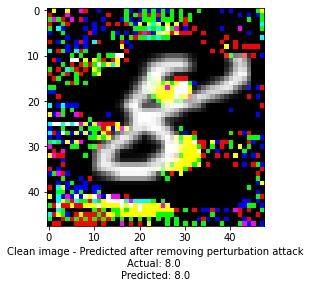

In [0]:
# Threshold < 0.4 return 0
roa_rep_heatmap[roa_rep_heatmap >= 0.5] = 1
roa_rep_heatmap[roa_rep_heatmap < 0.5] = 0
plt.imshow(roa_rep_heatmap, cmap='viridis')
plt.xlabel("Heatmap of perturbations of {0}".format(dataset))
plt.show()

 # Brighten ROA till to the point it does not exist - Keep information necessary for ROI - Minimise loss in prediction - Only ROI exist for classification 
_, data_test_demo = load_dataset(dataset)

for image in data_test_demo.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[1])).map(resize(dataset, number_of_classes, total_label_list[0])).take(1):
  plt.imshow(image["image"])
  plt.xlabel("Clean image - Predicted before removing perturbation attack\nActual: {0} \nPredicted: {1}".format(get_label(image["label"].numpy()), 
                                                                                                 predict_label_on_image(model, image["image"], 
                                                                                                                        display_info=True)))
  plt.show()
  # minus variance
  image["image"] = image["image"] + roa_rep_heatmap
  plt.imshow(image["image"])
  plt.xlabel("Clean image - Predicted after removing perturbation attack\nActual: {0} \nPredicted: {1}".format(get_label(image["label"].numpy()), 
                                                                                                 predict_label_on_image(model, image["image"], 
                                                                                                                        display_info=True)))
  plt.show()

## SSIM, MSE, NRMSE Comparison
- Individual Level
- Representative Level

In [0]:
# Function to generate ROI and ROA
def generate_roi_roa_indiv(dataset, model, data_item, eps):

  if dataset == "mnist" or dataset == "fashion_mnist" or dataset == "cifar10":

    image_size = (48, 48)

  elif dataset == "malaria":

    image_size = (128, 128)
  
  elif dataset == "oxford_flowers102" or dataset == "cats_vs_dogs":

    image_size = (224, 224)

  try:
    plt.figure()
    plt.imshow(data_item["image"])
    plt.show()

    print("Working on item #{0}".format(data_item["label"]))
    plt.imshow(data_item["image"])
    heatmap = generate_heatmap_region_inference(model, data_item["image"])
    heatmap = cv2.resize(heatmap, image_size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    plt.imshow(heatmap)
    plt.show()
    print(heatmap.shape)
    print("Generating perturb")
    (adv, perturb) = produce_adversarial_image(model, 
                                               data_item["image"], 
                                               data_item["label"], 
                                               epsilon=eps, 
                                               gradient_sign=1)
    perturb *= 0.1
    print(perturb.shape)

    plt.imshow(perturb)
    plt.show()

    print("Generating ssim")
    (score_ssim, diff) = structural_similarity(heatmap, 
                                              perturb, 
                                              full=True,  
                                              multichannel=True)
    print("SSIM between ROI and ROA: {:.5f}".format(score_ssim))
    print("Generating mse")
    score_mse = mean_squared_error(heatmap, perturb)
    print("MSE between ROI and ROA: {:.5f}".format(score_mse))
    print("Generating nrmse")
    score_nrmse = normalized_root_mse(heatmap, 
                                      perturb, 
                                      normalization='euclidean')
    print("NRMSE between ROI and ROA: {:.5f}".format(score_nrmse))

    return [data_item["label"], score_ssim, score_mse, score_nrmse]

  except error as e:
    print("Something went wrong")

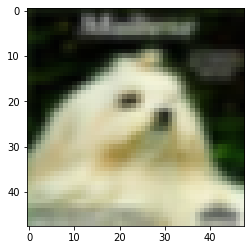

Working on item #[0. 1.]
(48, 48, 3)
(1, 48, 48, 3)


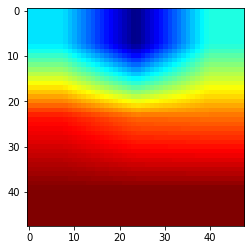

(48, 48, 3)
Generating perturb


(48, 48, 3)


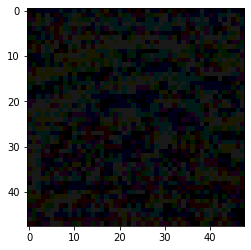

/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Generating ssim
SSIM between ROI and ROA: 0.33335
Generating mse
MSE between ROI and ROA: 22179.09255
Generating nrmse
NRMSE between ROI and ROA: 0.99998


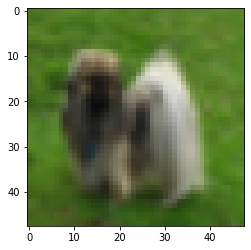

Working on item #[0. 1.]
(48, 48, 3)
(1, 48, 48, 3)


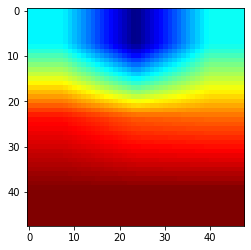

(48, 48, 3)
Generating perturb


(48, 48, 3)


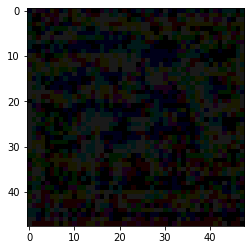

Generating ssim
SSIM between ROI and ROA: 0.33715
Generating mse
MSE between ROI and ROA: 22256.82337
Generating nrmse
NRMSE between ROI and ROA: 0.99999


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


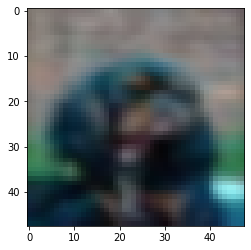

Working on item #[0. 1.]
(48, 48, 3)
(1, 48, 48, 3)


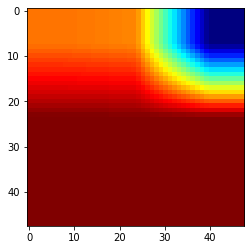

(48, 48, 3)
Generating perturb


(48, 48, 3)


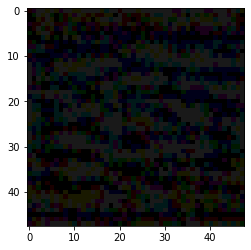

Generating ssim
SSIM between ROI and ROA: 0.48088
Generating mse
MSE between ROI and ROA: 14131.36391
Generating nrmse
NRMSE between ROI and ROA: 1.00000


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


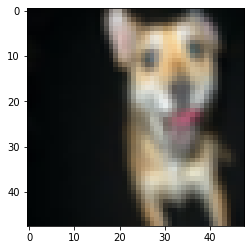

Working on item #[0. 1.]
(48, 48, 3)
(1, 48, 48, 3)


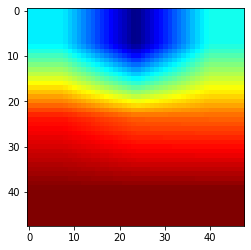

(48, 48, 3)
Generating perturb


(48, 48, 3)


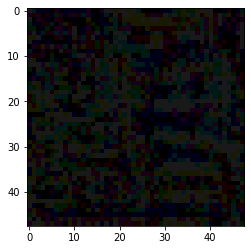

Generating ssim
SSIM between ROI and ROA: 0.33522
Generating mse
MSE between ROI and ROA: 22239.26310
Generating nrmse
NRMSE between ROI and ROA: 1.00000


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


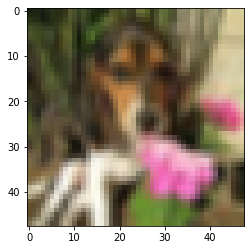

Working on item #[0. 1.]
(48, 48, 3)
(1, 48, 48, 3)


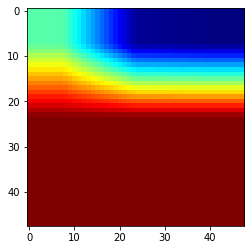

(48, 48, 3)
Generating perturb


(48, 48, 3)


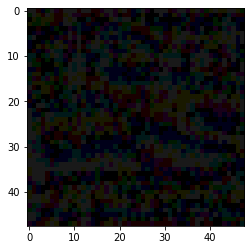

Generating ssim
SSIM between ROI and ROA: 0.42527
Generating mse
MSE between ROI and ROA: 14803.91732
Generating nrmse
NRMSE between ROI and ROA: 0.99998


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [0]:
getLocalList = list(data_test.filter(take_class(labelNumber=total_label_list[1])).map(resize(dataset, number_of_classes, total_label_list[0])).as_numpy_iterator())
g = len(getLocalList)

i = 0

for item in getLocalList:
  local_results = generate_roi_roa_indiv(dataset, model, item, 0.1)
  i += 1
  if i == 5:
    break                                                                               

In [0]:
# Function to generate ROI and ROA
def generate_roi_roa_representative(dataset, model, total_label_list, eps):

  if dataset == "mnist" or dataset == "fashion_mnist" or dataset == "cifar10":

    size = (48, 48)

  elif dataset == "malaria":

    size = (128, 128)
  
  elif dataset == "oxford_flowers102" or dataset == "cats_vs_dogs":

    size = (224, 224)

  
  roi_heatmap_stack = []
  roa_heatmap_stack = []
  for batch in data_test.shuffle(buffer_size=1024).filter(take_class(labelNumber=total_label_list[0])).map(resize(dataset, 
                                                                                                                  number_of_classes, 
                                                                                                                  total_label_list[0])).batch(1):    
    image = batch["image"][0]
    heatmap = generate_heatmap_region_inference(model, image)
    roi_heatmap_stack.append(heatmap)


  roi_rep_image = np.mean(roi_heatmap_stack, axis=0)
  roi_rep_image = cv2.resize(roi_rep_image, size)
  roi_rep_image = np.uint8(255 * roi_rep_image)
  roi_rep_image = cv2.applyColorMap(roi_rep_image, cv2.COLORMAP_JET)
  plt.imshow(roi_rep_image)
  plt.show()
  print(roi_rep_image.shape)

  roa_heatmap_stack = generate_heatmap_region_adversarial(dataset, model, total_label_list, eps)

  roa_rep_image = np.mean(roa_heatmap_stack, axis=0)
  plt.imshow(roa_rep_image)
  print(roa_rep_image.shape)
  plt.show()

  print("Generating ssim")
  (score_ssim, diff) = structural_similarity(roi_rep_image, 
                                              roa_rep_image, 
                                              full=True,  
                                              multichannel=True)
  print("SSIM between ROI and ROA: {:.5f}".format(score_ssim))
  print("Generating mse")
  score_mse = mean_squared_error(roi_rep_image, roa_rep_image)
  print("MSE between ROI and ROA: {:.5f}".format(score_mse))
  print("Generating nrmse")
  score_nrmse = normalized_root_mse(roi_rep_image, 
                                      roa_rep_image, 
                                      normalization='euclidean')
  print("NRMSE between ROI and ROA: {:.5f}".format(score_nrmse))

  # return [data_item["label"], score_ssim, score_mse, score_nrmse]

(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
(

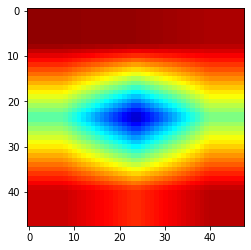

(48, 48, 3)


(48, 48, 3)


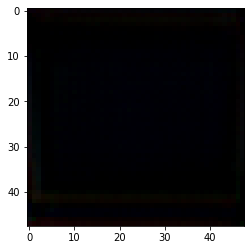

Generating ssim
SSIM between ROI and ROA: 0.22629
Generating mse
MSE between ROI and ROA: 24170.25096
Generating nrmse
NRMSE between ROI and ROA: 1.00000


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [0]:
local_results = generate_roi_roa_representative(dataset, model, total_label_list, 0.1)